# Modelo de OneClassSVM entrenado con 2F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- `../data/astro_df.txt`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.patches import Rectangle

from plotly.subplots import make_subplots

from scipy.stats import spearmanr, pearsonr

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

from mpl_toolkits.mplot3d import Axes3D

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configurar estilo
# plt.style.use('default')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Cargar dataset
data_path = "../data/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro = df_astro.rename(columns={"astro_DM": "class"})

print(f" Dataset cargado. Forma: {df_astro.shape}")
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro.head()

 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
 Dataset cargado. Forma: (2831, 5)
 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'class']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [4]:
# Selección de características
features = ['Log(E_peak)', 'Log(beta)']

"""Establecemos la columna objetivo aunque al ser un problema de detección de anomalías no la utilizaremos para entrenar el modelo.
Además de que todos los datos están etiquetados como 'astro_DM' = 0.0"""
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)']
Columna objetivo: class

 Valores faltantes por columna:
Log(E_peak)    0
Log(beta)      0
class          0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),class
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


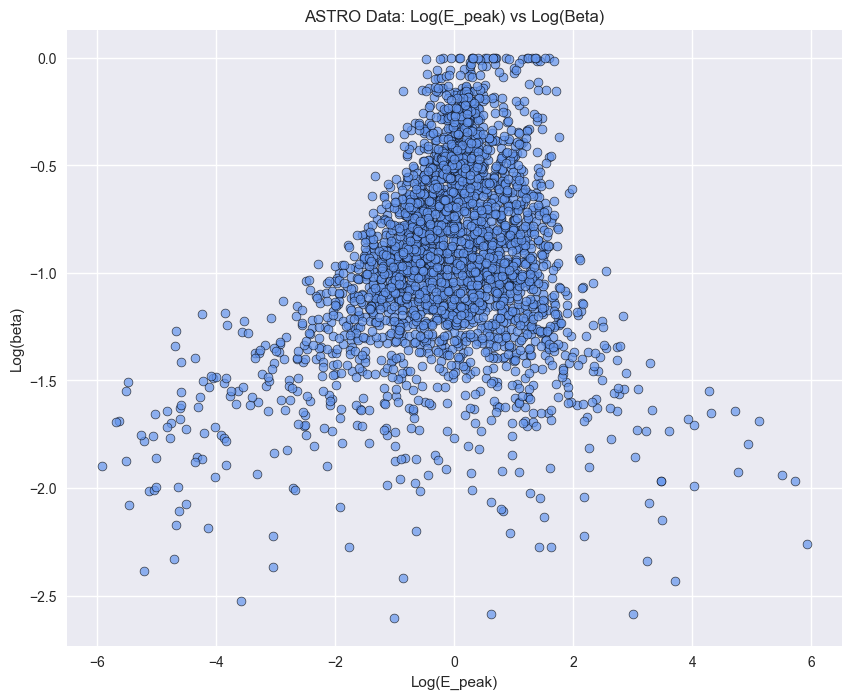

In [5]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue", "turquoise", "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

In [6]:
X = df_astro[features].values
y = df_astro[target].values

# SPLIT: Train / Val / Test
# 60% train, 20% val, 20% test
# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [7]:
print("Forma de X_train_scaled:", X_train_scaled.shape)
print("Forma de X_val_scaled:"  , X_val_scaled.shape)
print("Forma de X_test_scaled:", X_test_scaled.shape)

Forma de X_train_scaled: (1698, 2)
Forma de X_val_scaled: (566, 2)
Forma de X_test_scaled: (567, 2)


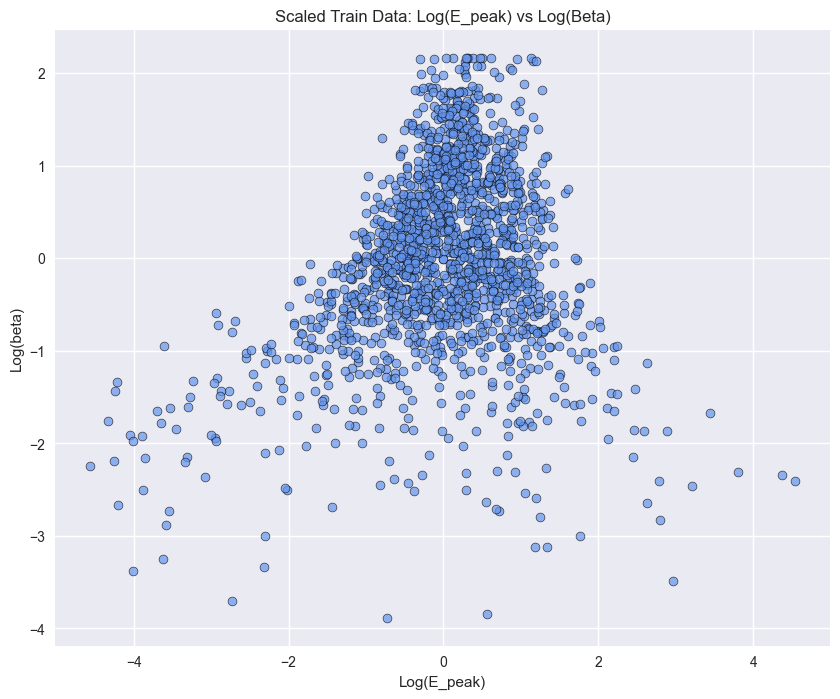

In [8]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()


In [9]:
# Hiperparámetros a explorar
nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
# gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))
gamma_values = [0.1]

# Tracking
results = []
best_outliers = np.inf
best_model = None
best_params = {}

# --- Grid Search ---

print("Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        # Predicciones
        preds_val = model.predict(X_val_scaled)  # 1 = normal, -1 = outlier
        pred_labels = np.where(preds_val == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int
        n_outliers = np.sum(preds_val == -1)
        # f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers})

        """
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}
        """
        if n_outliers < best_outliers:
            best_outliers = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Mostrar resultado óptimo
print(f"\n Mejor combinación de hiperparámetros:")
print(f"   - ν = {best_params['nu']}")
print(f"   - γ = {best_params['gamma']}")
print(f"Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

df_results = pd.DataFrame(results)
display(df_results.sort_values(by='val_outliers'))

Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

 Mejor combinación de hiperparámetros:
   - ν = 0.001
   - γ = 0.1
Outliers (val set): 3 de 566 muestras


,nu,gamma,val_outliers
0,0.001,0.1,3
1,0.002,0.1,3
2,0.005,0.1,4
3,0.010,0.1,8
4,0.020,0.1,19
5,0.050,0.1,36


In [10]:
"""# Evaluar el modelo en el conjunto de validación
val_preds = best_model.predict(X_val_scaled)
n_val_outliers = np.sum(val_preds == -1)
print(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")

# Evaluar el modelo en el conjunto de test
# (no se ha visto en el entrenamiento)
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)
print(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")"""

'# Evaluar el modelo en el conjunto de validación\nval_preds = best_model.predict(X_val_scaled)\nn_val_outliers = np.sum(val_preds == -1)\nprint(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")\n\n# Evaluar el modelo en el conjunto de test\n# (no se ha visto en el entrenamiento)\ntest_preds = best_model.predict(X_test_scaled)\nn_test_outliers = np.sum(test_preds == -1)\nprint(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")'

In [11]:
# Reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_params['nu'], gamma=best_params['gamma'])
final_model.fit(X_final_train_scaled)

OneClassSVM(gamma=0.1, nu=0.001)

In [12]:
# Evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Metricas
print(f"\n Evaluación en el conjunto de test:")
print(f"Outliers (test set): {np.sum(test_preds == -1)} de {len(X_test_scaled)} muestras")

print(f"\n Matriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)
print(f"\n Reporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))


 Evaluación en el conjunto de test:
Outliers (test set): 5 de 567 muestras

 Matriz de confusión:
[[562   5]
 [  0   0]]

 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       567
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       567
   macro avg       0.50      0.50      0.50       567
weighted avg       1.00      0.99      1.00       567



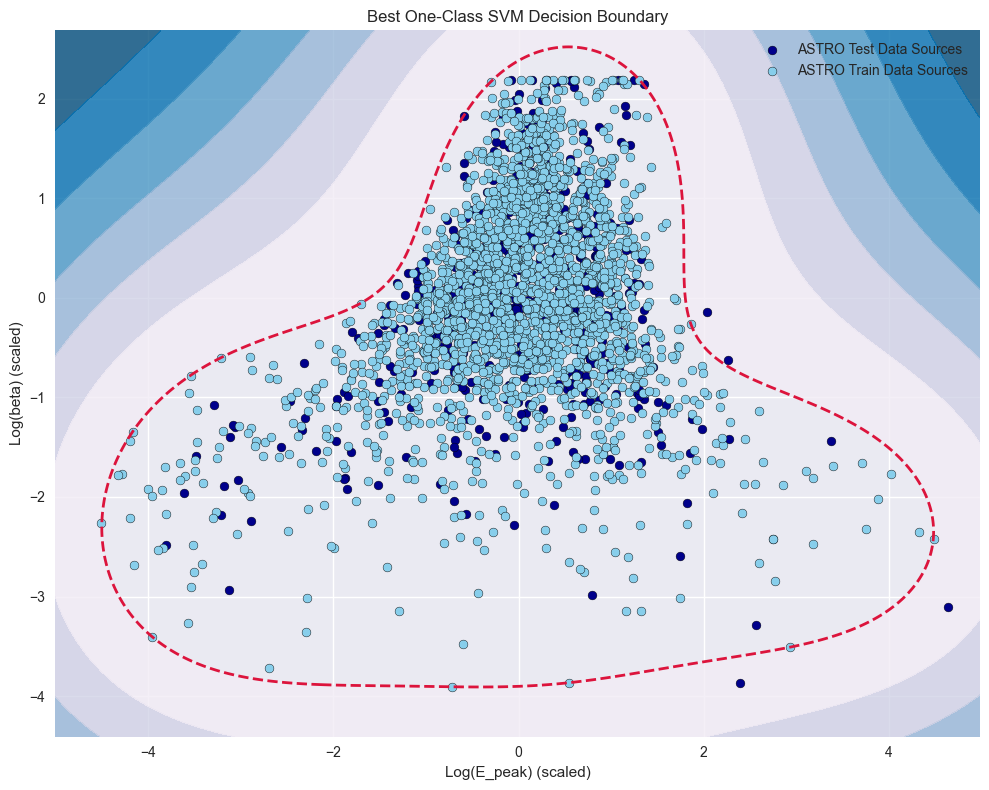

In [13]:
xx, yy = np.meshgrid(
    np.linspace(X_final_train_scaled[:, 0].min() - 0.5, X_final_train_scaled[:, 0].max() + 0.5, 300),  # Log(E_peak)
    np.linspace(X_final_train_scaled[:, 1].min() - 0.5, X_final_train_scaled[:, 1].max() + 0.5, 300)   # Log(beta)
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c='darkblue', edgecolors='k', s=40, label='ASTRO Test Data Sources')
plt.scatter(X_final_train_scaled[:, 0], X_final_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='ASTRO Train Data Sources')

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [14]:
# Cargar datos UnIDs
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

print("Datos UnIDs cargados:")
print(f"Shape: {df_unids.shape}")
print("Primeras filas:")
display(df_unids.head())

# Verificar columnas disponibles
print(f"Columnas disponibles: {list(df_unids.columns)}")

Datos UnIDs cargados:
Shape: (1125, 5)
Primeras filas:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


Columnas disponibles: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number']


In [15]:
# Extraer y escalar 
X_unids_log = df_unids[["Log(E_peak)", "Log(beta)"]].values
X_unids_scaled = scaler.transform(X_unids_log)

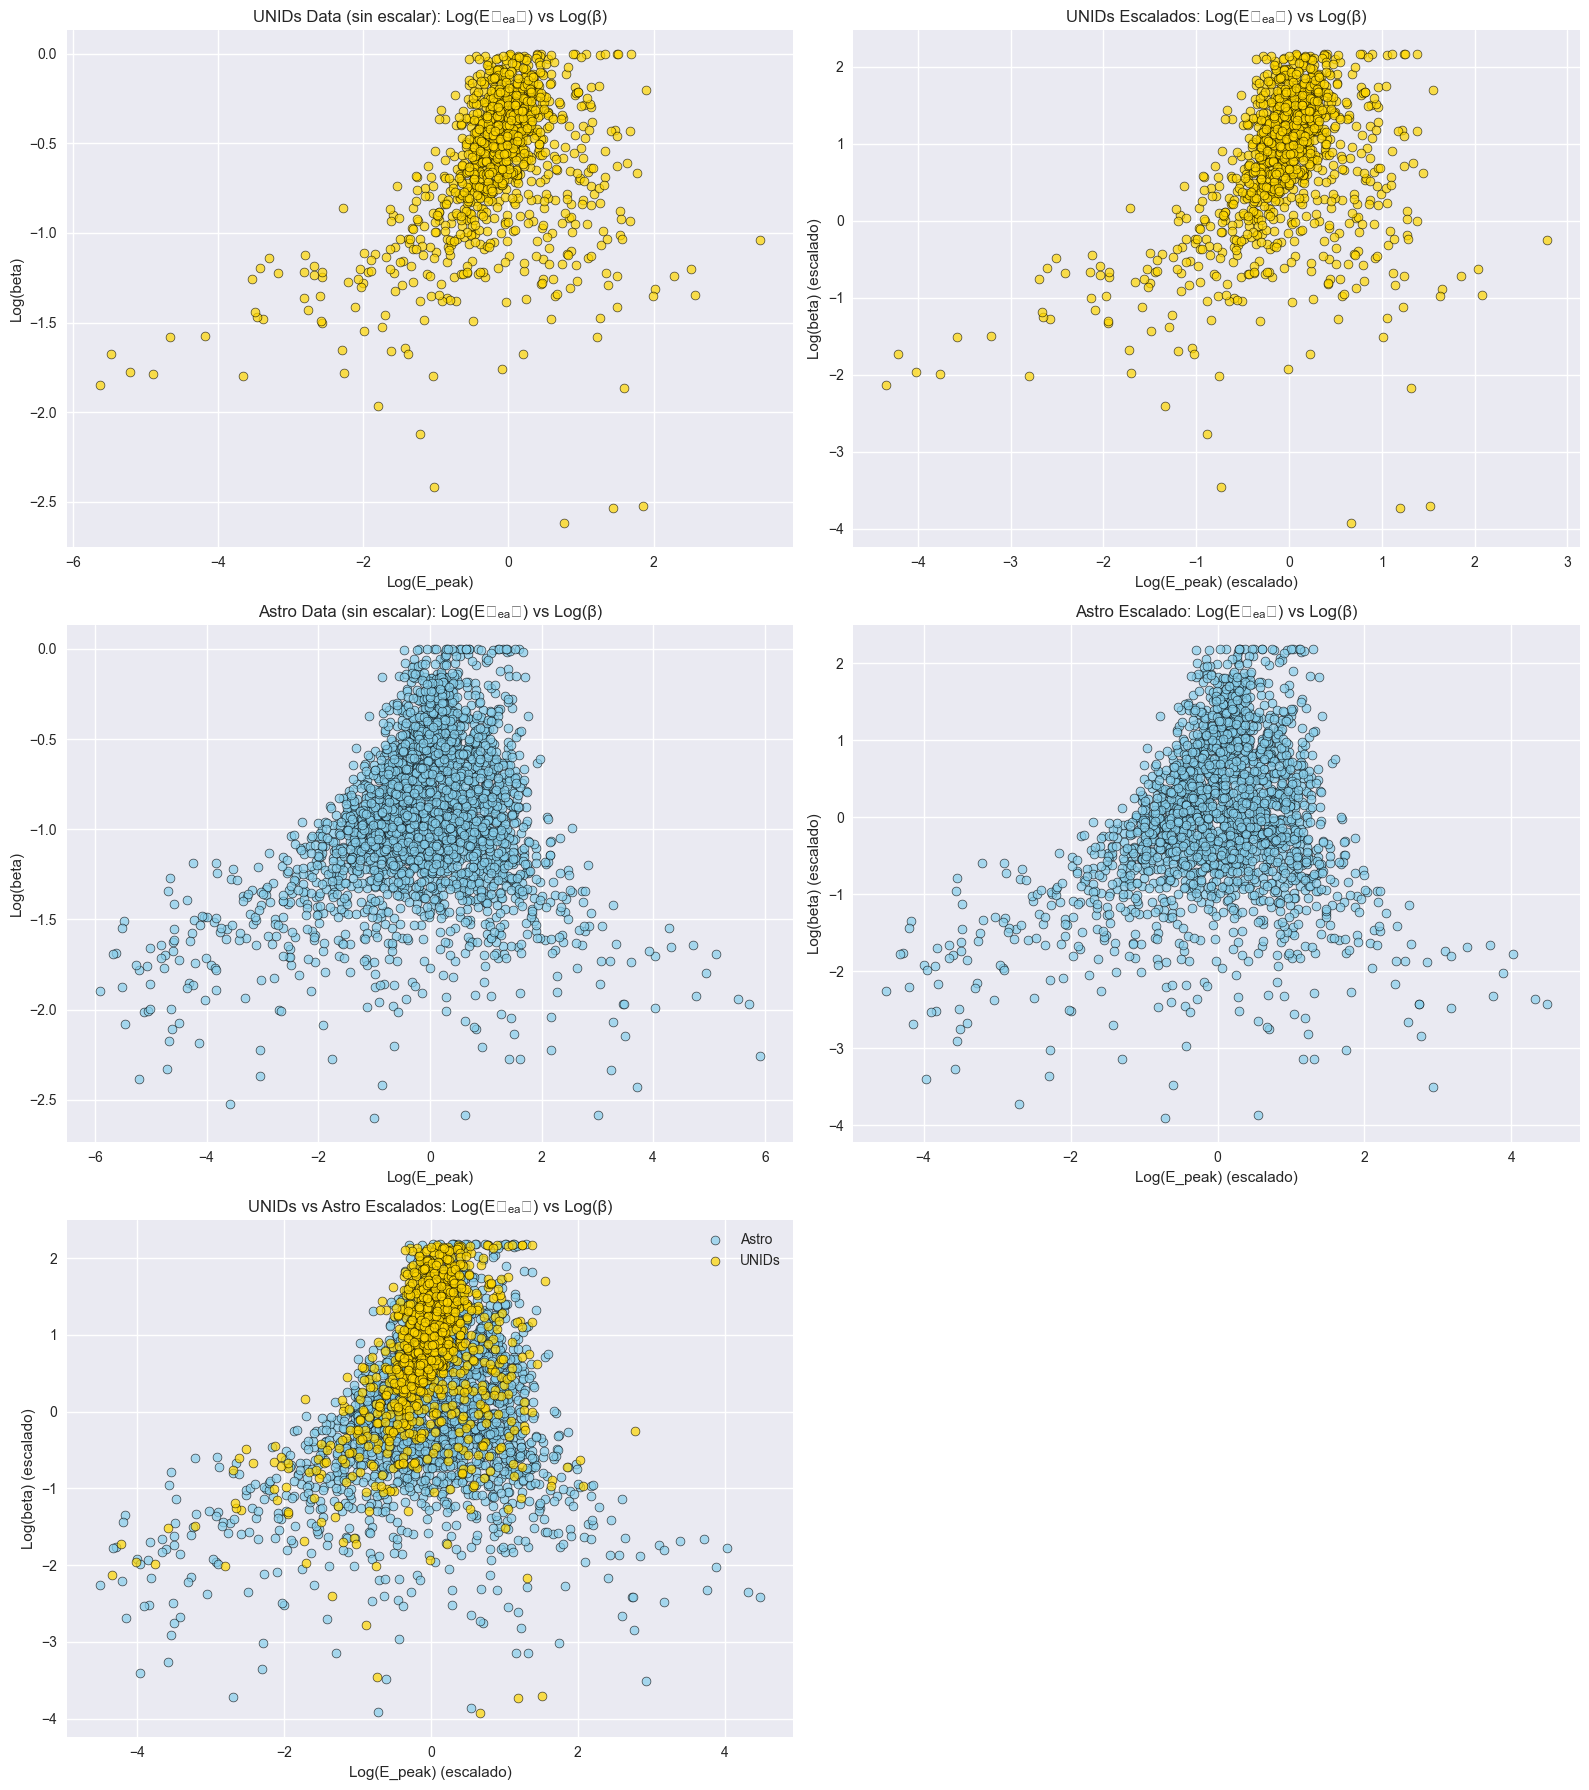

In [16]:
# --- Crear subplots 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Plot 1: UNIDs sin escalar ---
sns.scatterplot(
    data=df_unids,
    x="Log(E_peak)",
    y="Log(beta)",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 0]
)
axes[0, 0].set_title("UNIDs Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 0].set_xlabel("Log(E_peak)")
axes[0, 0].set_ylabel("Log(beta)")
axes[0, 0].grid(True)

# --- Plot 2: UNIDs escalados ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0, 1]
)
axes[0, 1].set_title("UNIDs Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[0, 1].set_xlabel("Log(E_peak) (escalado)")
axes[0, 1].set_ylabel("Log(beta) (escalado)")
axes[0, 1].grid(True)

# --- Plot 3: Astro sin escalar ---
sns.scatterplot(
    data=df_astro,  # asegúrate de tener este DataFrame cargado
    x="Log(E_peak)",
    y="Log(beta)",
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Astro Data (sin escalar): Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 0].set_xlabel("Log(E_peak)")
axes[1, 0].set_ylabel("Log(beta)")
axes[1, 0].grid(True)

# --- Plot 4: Astro escalado ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Astro Escalado: Log(Eₚₑₐₖ) vs Log(β)")
axes[1, 1].set_xlabel("Log(E_peak) (escalado)")
axes[1, 1].set_ylabel("Log(beta) (escalado)")
axes[1, 1].grid(True)

# --- Plot 5: Comparación UNIDs vs Astro escalados ---
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Astro',
    ax=axes[2, 0]
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='UNIDs',
    ax=axes[2, 0]
)
axes[2, 0].set_title("UNIDs vs Astro Escalados: Log(Eₚₑₐₖ) vs Log(β)")
axes[2, 0].set_xlabel("Log(E_peak) (escalado)")
axes[2, 0].set_ylabel("Log(beta) (escalado)")
axes[2, 0].legend()
axes[2, 0].grid(True)

# --- Eliminar celda vacía (3,2) ---
fig.delaxes(axes[2, 1])

# --- Layout final ---
plt.tight_layout()
plt.show()


In [17]:
# Predecir sobre UNIDs usando el mejor modelo
decision_scores = final_model.decision_function(X_unids_scaled)
unids_preds = final_model.predict(X_unids_scaled)

# Contar resultados
n_outliers = np.sum(unids_preds == -1)
n_inliers = np.sum(unids_preds == 1)
total_unids = len(unids_preds)

outlier_percentage = n_outliers / total_unids * 100
inlier_percentage = n_inliers / total_unids * 100

print(f"RESULTADOS DE PREDICCIÓN:")
print(f"  - Total UNIDs analizadas: {total_unids}")
print(f"  - Outliers detectados: {n_outliers} ({outlier_percentage:.1f}%)")
print(f"  - Inliers detectados: {n_inliers} ({inlier_percentage:.1f}%)")

# Calcular anomaly scores y rankings
# Invertir scores: valores más altos = más anómalos
anom_scores = -decision_scores

# Escalar a percentiles [0, 100]
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(
    anom_scores.reshape(-1, 1)
).flatten()

# Agregar resultados al DataFrame
df_unids_results = df_unids.copy()
df_unids_results["svm_score"] = decision_scores
df_unids_results["prediction"] = unids_preds
df_unids_results["Anomaly_Score"] = anom_scores
df_unids_results["Anomaly_Rank(%)"] = anom_percent

print("Scores calculados y agregados al DataFrame")

RESULTADOS DE PREDICCIÓN:
  - Total UNIDs analizadas: 1125
  - Outliers detectados: 4 (0.4%)
  - Inliers detectados: 1121 (99.6%)
Scores calculados y agregados al DataFrame


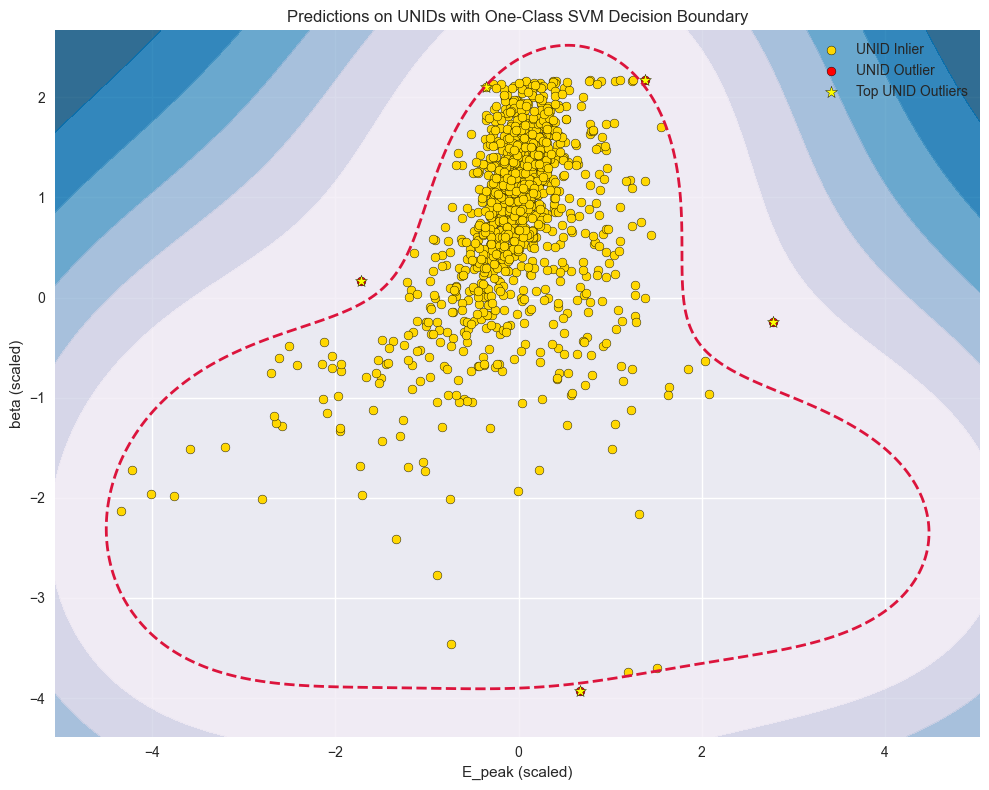

In [18]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = final_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNID Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNID Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = final_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 0], top_anomalies[:, 1], c='yellow', edgecolors='black', s=80, label='Top UNID Outliers', marker='*')


# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


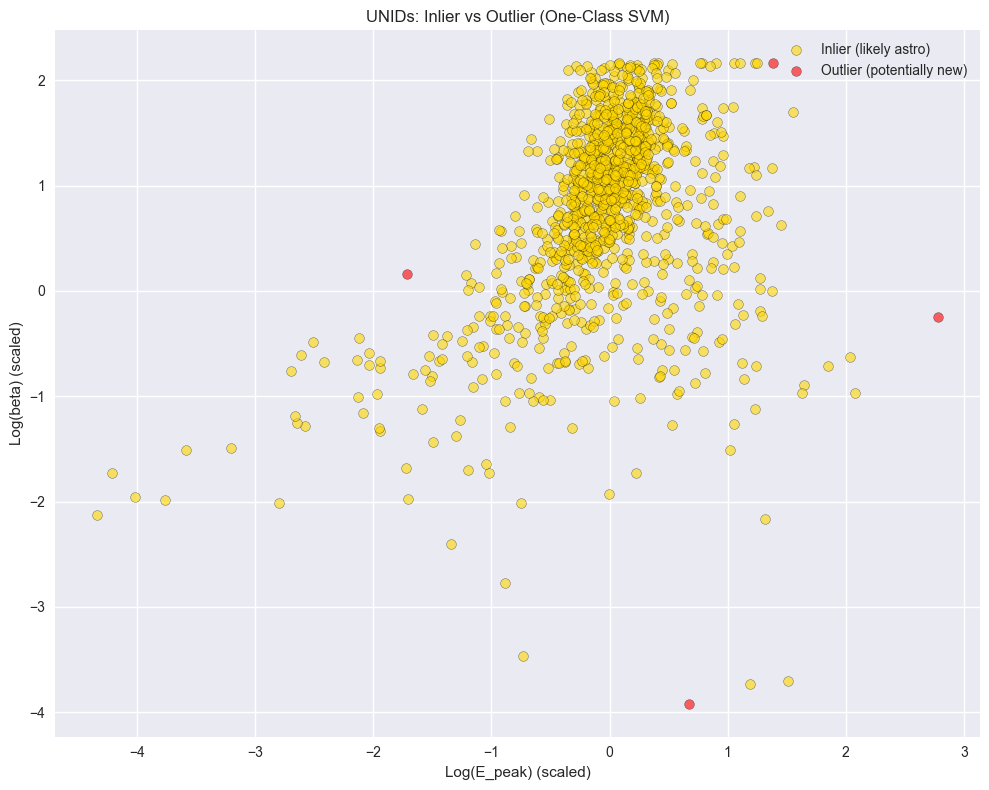

In [19]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(10, 8))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:,1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Anomaly Scoring - UNIDs

In [20]:
# Filtrar solo outliers y ordenar por anomaly rank
outliers_only = df_unids_results[df_unids_results["prediction"] == -1].copy()
outliers_sorted = outliers_only.sort_values(by="Anomaly_Rank(%)", ascending=False)

# Top 10 outliers más anómalos
top_10_outliers = outliers_sorted.head(10)

print(f"\nTOP 10 CANDIDATOS MÁS ANÓMALOS:")

# Mostrar información relevante
display_cols = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 
                'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']

if 'number' in df_unids_results.columns:
    display_cols = ['number'] + display_cols

display(top_10_outliers[display_cols].round(10))


TOP 10 CANDIDATOS MÁS ANÓMALOS:


,number,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),svm_score,Anomaly_Score,Anomaly_Rank(%)
1054,1054,3.469896,-1.037631,0.679664,0.317981,-0.036636,0.036636,100.000000
275,275,-2.278140,-0.862013,0.806424,-0.002854,-0.009451,0.009451,78.078019
1116,1116,0.771404,-2.619789,0.747319,1.599337,-0.005686,0.005686,75.041503
1017,1017,1.682984,-0.000087,0.632690,-1.191027,-0.003810,0.003810,73.528997


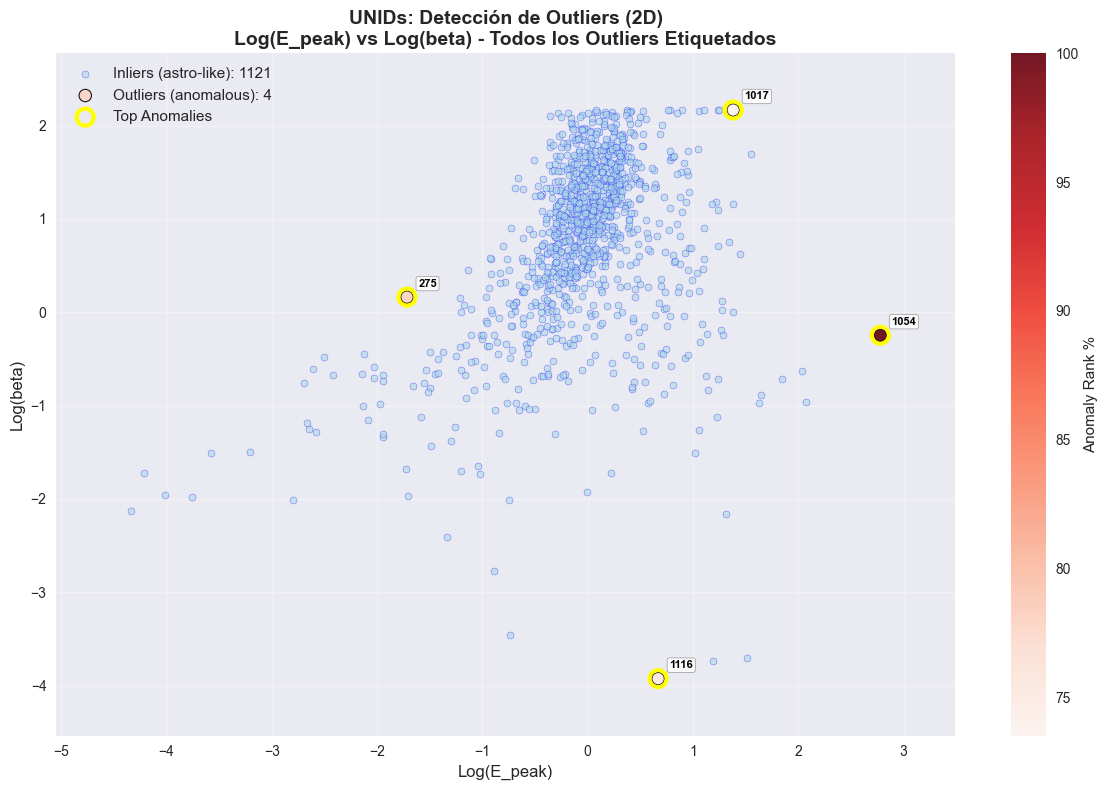

In [21]:
# Configuración de la gráfica
plt.figure(figsize=(12, 8))

# Separar inliers y outliers
inliers_mask = unids_preds == 1
outliers_mask = unids_preds == -1

# Plot inliers (usando las dos primeras features: Log(E_peak) vs Log(beta))
plt.scatter(X_unids_scaled[inliers_mask, 0], X_unids_scaled[inliers_mask, 1], 
           c='lightblue', s=25, alpha=0.6, edgecolors='blue', linewidth=0.3,
           label=f'Inliers (astro-like): {np.sum(inliers_mask)}')

# Plot outliers con gradient de color según anomaly rank
if np.any(outliers_mask):
    scatter = plt.scatter(X_unids_scaled[outliers_mask, 0], X_unids_scaled[outliers_mask, 1], 
                         c=anom_percent[outliers_mask], cmap='Reds', s=80,
                         alpha=0.9, edgecolors='black', linewidth=0.8,
                         label=f'Outliers (anomalous): {np.sum(outliers_mask)}')
    
    # Colorbar
    cbar = plt.colorbar(scatter, label='Anomaly Rank %')
    cbar.ax.tick_params(labelsize=10)

# Etiquetar TODOS los outliers con sus IDs
if np.any(outliers_mask):
    outlier_indices = np.where(outliers_mask)[0]
    
    for idx in outlier_indices:
        x = X_unids_scaled[idx, 0]  # Log(E_peak)
        y = X_unids_scaled[idx, 1]  # Log(beta)
        
        # Obtener el ID del UNID
        if 'number' in df_unids_results.columns:
            unid_id = int(df_unids_results.loc[idx, 'number'])
        else:
            unid_id = idx
        
        # Calcular offset para evitar solapamientos
        offset_x = (X_unids_scaled[:, 0].max() - X_unids_scaled[:, 0].min()) * 0.015
        offset_y = (X_unids_scaled[:, 1].max() - X_unids_scaled[:, 1].min()) * 0.015
        
        # Etiqueta con caja para mejor legibilidad
        plt.text(x + offset_x, y + offset_y, str(unid_id), 
                fontsize=8, color='black', fontweight='bold',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                         alpha=0.8, edgecolor='gray', linewidth=0.5))

# Destacar top 10 anomalías con círculos amarillos
if 'top_10_outliers' in locals() and len(top_10_outliers) > 0:
    top_10_indices = top_10_outliers.index
    plt.scatter(X_unids_scaled[top_10_indices, 0], X_unids_scaled[top_10_indices, 1],
               s=150, facecolors='none', edgecolors='yellow', linewidth=3,
               label=f'Top Anomalies', marker='o')

# Configuración de la gráfica
plt.xlabel('Log(E_peak)', fontsize=12)
plt.ylabel('Log(beta)', fontsize=12)
plt.title('UNIDs: Detección de Outliers (2D)\nLog(E_peak) vs Log(beta) - Todos los Outliers Etiquetados', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

# Ajustar límites para mejor visualización de etiquetas
x_margin = (X_unids_scaled[:, 0].max() - X_unids_scaled[:, 0].min()) * 0.1
y_margin = (X_unids_scaled[:, 1].max() - X_unids_scaled[:, 1].min()) * 0.1
plt.xlim(X_unids_scaled[:, 0].min() - x_margin, X_unids_scaled[:, 0].max() + x_margin)
plt.ylim(X_unids_scaled[:, 1].min() - y_margin, X_unids_scaled[:, 1].max() + y_margin)

plt.tight_layout()
plt.show()

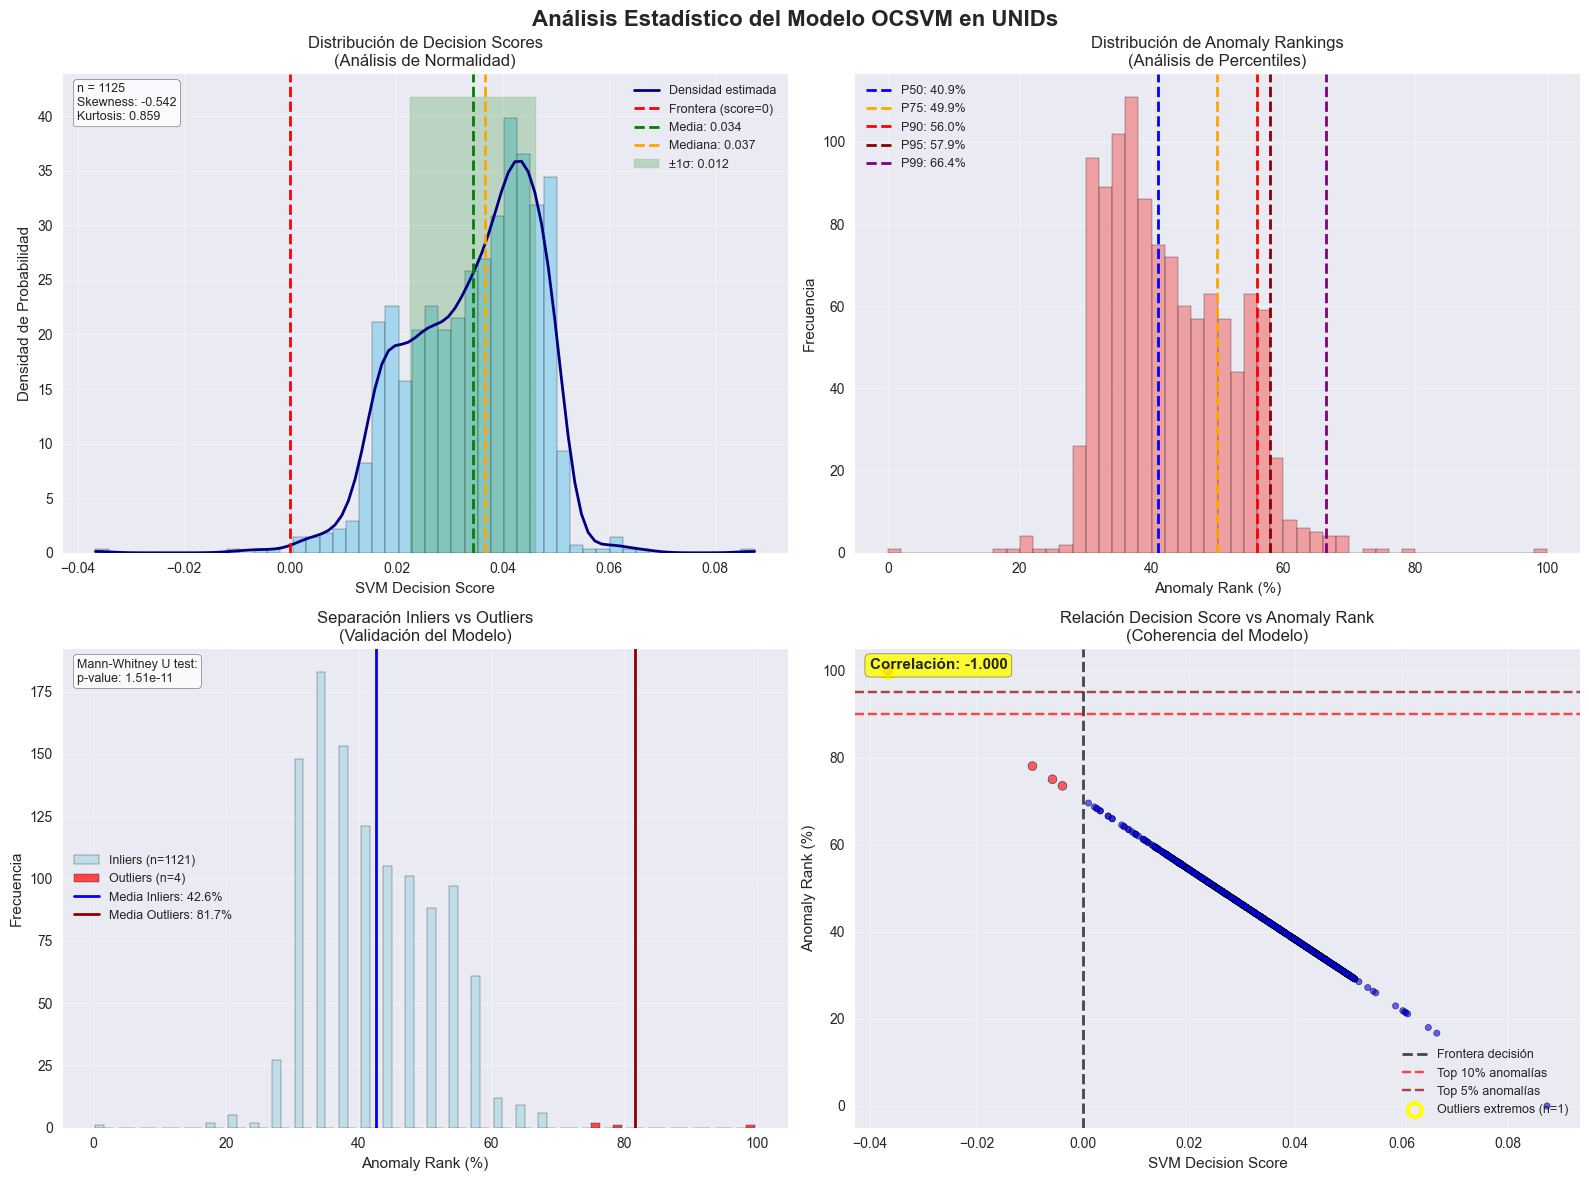

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Estadístico del Modelo OCSVM en UNIDs', fontsize=16, fontweight='bold', y=0.98)

# 1. Distribución de Decision Scores CON ESTADÍSTICAS
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(decision_scores, bins=50, alpha=0.7, color='skyblue', 
                           edgecolor='black', density=True)

# Añadir curva de densidad suavizada
x_smooth = np.linspace(decision_scores.min(), decision_scores.max(), 100)
density = stats.gaussian_kde(decision_scores)
ax1.plot(x_smooth, density(x_smooth), 'navy', linewidth=2, label='Densidad estimada')

# Líneas de referencia
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Frontera (score=0)')
ax1.axvline(decision_scores.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Media: {decision_scores.mean():.3f}')
ax1.axvline(np.median(decision_scores), color='orange', linestyle='--', linewidth=2,
           label=f'Mediana: {np.median(decision_scores):.3f}')

# Estadísticas adicionales
std_dev = decision_scores.std()
ax1.fill_betweenx([0, ax1.get_ylim()[1]], decision_scores.mean()-std_dev, 
                  decision_scores.mean()+std_dev, alpha=0.2, color='green', 
                  label=f'±1σ: {std_dev:.3f}')

ax1.set_xlabel('SVM Decision Score')
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_title('Distribución de Decision Scores\n(Análisis de Normalidad)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Texto con estadísticas
stats_text = f'n = {len(decision_scores)}\nSkewness: {stats.skew(decision_scores):.3f}\nKurtosis: {stats.kurtosis(decision_scores):.3f}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribución de Anomaly Ranks CON PERCENTILES
ax2 = axes[0, 1]
ax2.hist(anom_percent, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')

# Percentiles importantes
percentiles = [50, 75, 90, 95, 99]
colors = ['blue', 'orange', 'red', 'darkred', 'purple']
for p, color in zip(percentiles, colors):
    value = np.percentile(anom_percent, p)
    ax2.axvline(value, color=color, linestyle='--', linewidth=2, 
               label=f'P{p}: {value:.1f}%')

ax2.set_xlabel('Anomaly Rank (%)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Anomaly Rankings\n(Análisis de Percentiles)')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Comparación Inliers vs Outliers
ax3 = axes[1, 0]
outliers_scores = anom_percent[unids_preds == -1]
inliers_scores = anom_percent[unids_preds == 1]

# Histograma
bins = np.linspace(0, 100, 31)
ax3.hist([inliers_scores, outliers_scores], bins=bins, alpha=0.7,
         color=['lightblue', 'red'], label=[f'Inliers (n={len(inliers_scores)})', 
                                           f'Outliers (n={len(outliers_scores)})'],
         edgecolor='black')

# Añadir líneas de medias
ax3.axvline(inliers_scores.mean(), color='blue', linestyle='-', linewidth=2,
           label=f'Media Inliers: {inliers_scores.mean():.1f}%')
ax3.axvline(outliers_scores.mean(), color='darkred', linestyle='-', linewidth=2,
           label=f'Media Outliers: {outliers_scores.mean():.1f}%')

ax3.set_xlabel('Anomaly Rank (%)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Separación Inliers vs Outliers\n(Validación del Modelo)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Test estadístico
stat, p_value = stats.mannwhitneyu(outliers_scores, inliers_scores, alternative='greater')
test_text = f'Mann-Whitney U test:\np-value: {p_value:.2e}'
ax3.text(0.02, 0.98, test_text, transform=ax3.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Scatter con regiones de interés
ax4 = axes[1, 1]
colors = ['red' if pred == -1 else 'blue' for pred in unids_preds]
sizes = [40 if pred == -1 else 20 for pred in unids_preds]

scatter = ax4.scatter(decision_scores, anom_percent, c=colors, alpha=0.6, s=sizes,
                     edgecolors='black', linewidth=0.5)

# Regiones de interés
ax4.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Frontera decisión')
ax4.axhline(90, color='red', linestyle='--', alpha=0.7, label='Top 10% anomalías')
ax4.axhline(95, color='darkred', linestyle='--', alpha=0.7, label='Top 5% anomalías')

# Destacar zona de interés (outliers extremos)
extreme_mask = (unids_preds == -1) & (anom_percent > 95)
if np.any(extreme_mask):
    ax4.scatter(decision_scores[extreme_mask], anom_percent[extreme_mask], 
               s=100, facecolors='none', edgecolors='yellow', linewidth=3,
               label=f'Outliers extremos (n={np.sum(extreme_mask)})')

# Correlación
correlation = np.corrcoef(decision_scores, anom_percent)[0, 1]
ax4.text(0.02, 0.98, f'Correlación: {correlation:.3f}', transform=ax4.transAxes, 
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax4.set_xlabel('SVM Decision Score')
ax4.set_ylabel('Anomaly Rank (%)')
ax4.set_title('Relación Decision Score vs Anomaly Rank\n(Coherencia del Modelo)')
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [23]:
# Cargar resultados del consenso ANN 2F
ann_consensus = pd.read_csv('../data/results/ann/2F/consensus_analysis_ann_2f.csv')
print(f"Resultados ANN 2F cargados: {len(ann_consensus)} fuentes")

# Usar los resultados OCSVM con predicciones (NO df_unids original)
ocsvm_results = df_unids_results.copy()  # Ya tiene las predicciones y scores
print(f"Resultados OCSVM 2F cargados: {len(ocsvm_results)} fuentes")

# Verificar mismo número de fuentes
if len(ann_consensus) != len(ocsvm_results):
    print(f" ADVERTENCIA: Diferentes números de fuentes - ANN: {len(ann_consensus)}, OCSVM: {len(ocsvm_results)}")
else:
    print(f"Mismo número de fuentes: {len(ann_consensus)}")

Resultados ANN 2F cargados: 1125 fuentes
Resultados OCSVM 2F cargados: 1125 fuentes
Mismo número de fuentes: 1125


In [24]:
print("Resultados (top unids) consenso ANN 2F:")
ann_consensus.head()

Resultados (top unids) consenso ANN 2F:


,Source_ID,E_peak,Beta,log_E_peak,log_Beta,Prob_Run1,Prob_Run2,Prob_Run3,Std_Run1,Std_Run2,Std_Run3,Mean_Prob_Consensus,Std_Prob_Consensus,Min_Prob_Consensus,Max_Prob_Consensus,Mean_Uncertainty_Consensus
0,664,1.495800,0.4329,0.174874,-0.363612,0.542419,0.491962,0.529205,0.319640,0.303699,0.318839,0.521195,0.026165,0.491962,0.542419,0.314059
1,1114,1.294500,0.3280,0.112102,-0.484126,0.518394,0.469855,0.510559,0.301546,0.229365,0.320803,0.499603,0.026059,0.469855,0.518394,0.283905
2,551,1.209400,0.2911,0.082570,-0.535958,0.518128,0.465619,0.507623,0.319284,0.233885,0.297997,0.497123,0.027784,0.465619,0.518128,0.283722
3,101,0.025961,0.1263,-1.585679,-0.898597,0.513475,0.459180,0.504768,0.311790,0.260753,0.303923,0.492474,0.029160,0.459180,0.513475,0.292155
4,663,0.064547,0.0851,-1.190124,-1.070070,0.495285,0.451706,0.489790,0.233247,0.068487,0.051215,0.478927,0.023734,0.451706,0.495285,0.117650


In [25]:
print('Resultados (todos) OCSVM 2F:')
ocsvm_results.head()

Resultados (todos) OCSVM 2F:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%)
0,0.400175,-1.047208,0.869208,0.212452,0,0.021554,1,-0.021554,53.075119
1,0.169733,-0.380594,0.733598,-0.113037,1,0.048864,1,-0.048864,31.051808
2,0.203142,-0.168578,1.033058,-0.430366,2,0.041107,1,-0.041107,37.307077
3,-0.031074,-0.557363,0.881133,-0.201588,3,0.043333,1,-0.043333,35.512092
4,-0.351835,-0.493901,0.630916,-0.246028,4,0.037700,1,-0.037700,40.054884


In [26]:
# Verificar alineamiento de IDs
ann_ids = ann_consensus['Source_ID'].values
ocsvm_ids = ocsvm_results['number'].values if 'number' in ocsvm_results.columns else ocsvm_results.index.values

ids_aligned = np.array_equal(ann_ids, ocsvm_ids)

if ids_aligned:
    print("Los IDs están alineados correctamente")
    ann_final = ann_consensus.copy()
    ocsvm_final = ocsvm_results.copy()
else:
    print("Los IDs NO están alineados - procediendo a alinear...")
    print(f"   Primeros 5 IDs ANN: {ann_ids[:5]}")
    print(f"   Primeros 5 IDs OCSVM: {ocsvm_ids[:5]}")
    
    # Alinear por ID común
    if 'number' in ocsvm_results.columns:
        ann_final = ann_consensus.sort_values('Source_ID').reset_index(drop=True)
        ocsvm_final = ocsvm_results.sort_values('number').reset_index(drop=True)
        
        # Verificar alineamiento después de ordenar
        if np.array_equal(ann_final['Source_ID'].values, ocsvm_final['number'].values):
            print("IDs alineados correctamente después de ordenar")
        else:
            print("ERROR: No se pudieron alinear los IDs - revisar datos")
            # Mostrar diferencias
            ann_set = set(ann_final['Source_ID'].values)
            ocsvm_set = set(ocsvm_final['number'].values)
            print(f"   IDs solo en ANN: {ann_set - ocsvm_set}")
            print(f"   IDs solo en OCSVM: {ocsvm_set - ann_set}")
    else:
        print("ERROR: Columna 'number' no encontrada en OCSVM results")
        ann_final = ann_consensus.copy()
        ocsvm_final = ocsvm_results.copy()

Los IDs NO están alineados - procediendo a alinear...
   Primeros 5 IDs ANN: [ 664 1114  551  101  663]
   Primeros 5 IDs OCSVM: [0 1 2 3 4]
IDs alineados correctamente después de ordenar


In [27]:
# CREAR DATAFRAME COMBINADO

# Verificar columnas necesarias existen
required_ann_cols = ['Source_ID', 'E_peak', 'Beta', 'log_E_peak', 'log_Beta', 'Mean_Prob_Consensus', 'Std_Prob_Consensus']
required_ocsvm_cols = ['prediction', 'Anomaly_Score', 'Anomaly_Rank(%)']

missing_ann = [col for col in required_ann_cols if col not in ann_final.columns]
missing_ocsvm = [col for col in required_ocsvm_cols if col not in ocsvm_final.columns]

if missing_ann:
    print(f"Columnas faltantes en ANN: {missing_ann}")
if missing_ocsvm:
    print(f"Columnas faltantes en OCSVM: {missing_ocsvm}")

if not missing_ann and not missing_ocsvm:
    comparison_df = pd.DataFrame({
        # IDs y características originales
        'Source_ID': ann_final['Source_ID'].values,
        'E_peak': ann_final['E_peak'].values,
        'Beta': ann_final['Beta'].values,
        'Log_E_peak': ann_final['log_E_peak'].values,
        'Log_Beta': ann_final['log_Beta'].values,
        
        # Resultados ANN 2F
        'ANN_Prob_Mean': ann_final['Mean_Prob_Consensus'].values,
        'ANN_Prob_Std': ann_final['Std_Prob_Consensus'].values,
        
        # Resultados OCSVM 2F
        'OCSVM_Prediction': ocsvm_final['prediction'].values,  # 1=inlier, -1=outlier
        'OCSVM_Anomaly_Score': ocsvm_final['Anomaly_Score'].values,
        'OCSVM_Anomaly_Rank': ocsvm_final['Anomaly_Rank(%)'].values,
    })
    
else:
    print("No se pudo crear el DataFrame combinado debido a columnas faltantes")
    comparison_df = None

In [28]:
# DIAGNÓSTICO DIRECTO ANN 2F vs OCSVM 2F
print("DIAGNÓSTICO ANN 2F vs OCSVM 2F")

print("-" * 60)
print(f"ANN 2F - Media: {comparison_df['ANN_Prob_Mean'].mean():.4f} | "
      f"Mediana: {comparison_df['ANN_Prob_Mean'].median():.4f} | "
      f"Rango: [{comparison_df['ANN_Prob_Mean'].min():.4f}-{comparison_df['ANN_Prob_Mean'].max():.4f}]")

print(f"OCSVM 2F - Media: {comparison_df['OCSVM_Anomaly_Rank'].mean():.1f}% | "
      f"Mediana: {comparison_df['OCSVM_Anomaly_Rank'].median():.1f}% | "
      f"Rango: [{comparison_df['OCSVM_Anomaly_Rank'].min():.1f}%-{comparison_df['OCSVM_Anomaly_Rank'].max():.1f}%]")

# IDENTIFICACIÓN DE CANDIDATOS
print("-" * 60)
print(f"\nIDENTIFICACIÓN DE CANDIDATOS:")
ann_threshold = np.percentile(comparison_df['ANN_Prob_Mean'], 95)
ocsvm_threshold = np.percentile(comparison_df['OCSVM_Anomaly_Rank'], 95)

top_ann = comparison_df[comparison_df['ANN_Prob_Mean'] >= ann_threshold].sort_values('ANN_Prob_Mean', ascending=False)
ocsvm_outliers = comparison_df[comparison_df['OCSVM_Prediction'] == -1].sort_values('OCSVM_Anomaly_Rank', ascending=False)
top_ocsvm = comparison_df[comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold].sort_values('OCSVM_Anomaly_Rank', ascending=False)

print(f"Top ANN (P95={ann_threshold:.4f}): {len(top_ann)} fuentes")
print(f"OCSVM Outliers: {len(ocsvm_outliers)} fuentes")
print(f"Top OCSVM (P95={ocsvm_threshold:.1f}%): {len(top_ocsvm)} fuentes")

# SOLAPAMIENTOS
print(f"\nSOLAPAMIENTOS:")
overlap_restrictivo = set(top_ann['Source_ID']) & set(ocsvm_outliers['Source_ID'])
overlap_amplio = set(top_ann['Source_ID']) & set(top_ocsvm['Source_ID'])

print(f"Top ANN ∩ OCSVM Outliers: {len(overlap_restrictivo)} fuentes")
if overlap_restrictivo:
    print(f"  IDs: {sorted(list(overlap_restrictivo))}")

print(f"Top ANN ∩ Top OCSVM: {len(overlap_amplio)} fuentes")
if overlap_amplio:
    print(f"  IDs: {sorted(list(overlap_amplio))}")

# TOP 10 COMPARACIÓN DIRECTA
print(f"\nTOP 10 ANN vs OCSVM:")
print("-" * 60)
for i, (_, row) in enumerate(top_ann.head(10).iterrows()):
    status = "Outlier" if row['OCSVM_Prediction'] == -1 else "Normal"
    print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: ANN={row['ANN_Prob_Mean']:.4f} | OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% {status}")

print(f"\nOUTLIERS OCSVM vs ANN:")
print("-" * 60)
if len(ocsvm_outliers) > 0:
    for i, (_, row) in enumerate(ocsvm_outliers.iterrows()):
        print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% | ANN={row['ANN_Prob_Mean']:.4f}")
else:
    print("No hay outliers detectados por OCSVM")

# ANÁLISIS DE CONCORDANCIA
print(f"\nANÁLISIS DE CONCORDANCIA:")
# Correlación entre métricas
correlation = np.corrcoef(comparison_df['ANN_Prob_Mean'], comparison_df['OCSVM_Anomaly_Rank'])[0, 1]
print(f"Correlación ANN-OCSVM: {correlation:.4f}")

# Concordancia en clasificación binaria
ann_high = comparison_df['ANN_Prob_Mean'] >= ann_threshold
ocsvm_high = comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold

concordancia = np.mean(ann_high == ocsvm_high) * 100
print(f"Concordancia en top 5%: {concordancia:.1f}%")

# Casos discrepantes
discrepantes_ann_high_ocsvm_low = comparison_df[(comparison_df['ANN_Prob_Mean'] >= ann_threshold) & 
                                               (comparison_df['OCSVM_Anomaly_Rank'] < 50)]
discrepantes_ocsvm_high_ann_low = comparison_df[(comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold) & 
                                               (comparison_df['ANN_Prob_Mean'] < 0.5)]

print(f"Discrepantes (ANN alta, OCSVM baja): {len(discrepantes_ann_high_ocsvm_low)}")
print(f"Discrepantes (OCSVM alta, ANN baja): {len(discrepantes_ocsvm_high_ann_low)}")

print("-" * 60)
# RESUMEN EJECUTIVO
print(f"\nRESUMEN EJECUTIVO:")
if len(overlap_restrictivo) > 0:
    print(f"Consenso encontrado: {len(overlap_restrictivo)} fuentes identificadas por ambos métodos")
else:
    print("Sin consenso directo entre métodos")

if abs(correlation) > 0.5:
    print(f"Correlación moderada-alta: {correlation:.3f}")
else:
    print(f"Correlación baja: {correlation:.3f}")

if concordancia > 70:
    print(f"Buena concordancia en top candidatos: {concordancia:.1f}%")
else:
    print(f"Baja concordancia en top candidatos: {concordancia:.1f}%")

DIAGNÓSTICO ANN 2F vs OCSVM 2F
------------------------------------------------------------
ANN 2F - Media: 0.2830 | Mediana: 0.2804 | Rango: [0.0201-0.5212]
OCSVM 2F - Media: 42.7% | Mediana: 40.9% | Rango: [0.0%-100.0%]
------------------------------------------------------------

IDENTIFICACIÓN DE CANDIDATOS:
Top ANN (P95=0.4090): 57 fuentes
OCSVM Outliers: 4 fuentes
Top OCSVM (P95=57.9%): 57 fuentes

SOLAPAMIENTOS:
Top ANN ∩ OCSVM Outliers: 0 fuentes
Top ANN ∩ Top OCSVM: 4 fuentes
  IDs: [101, 127, 583, 1113]

TOP 10 ANN vs OCSVM:
------------------------------------------------------------
 1. ID  664: ANN=0.5212 | OCSVM= 31.1% Normal
 2. ID 1114: ANN=0.4996 | OCSVM= 32.3% Normal
 3. ID  551: ANN=0.4971 | OCSVM= 33.7% Normal
 4. ID  101: ANN=0.4925 | OCSVM= 64.1% Normal
 5. ID  663: ANN=0.4789 | OCSVM= 56.9% Normal
 6. ID   96: ANN=0.4727 | OCSVM= 51.2% Normal
 7. ID  138: ANN=0.4660 | OCSVM= 54.6% Normal
 8. ID 1113: ANN=0.4625 | OCSVM= 58.4% Normal
 9. ID  560: ANN=0.4594 | OCSV